In [78]:
import pandas as pd
import numpy as np
import requests
from ydata_profiling import ProfileReport
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import featuretools as ft
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [153]:
# Function to fetch data for a given date range
def fetch_hourly_data(start_date, end_date):
    url = "https://meteostat.p.rapidapi.com/point/hourly"

    querystring = {
        "lat": 24.8607,
        "lon": 67.0011,
        "alt": 8,
        "start": start_date,
        "end": end_date,
        "hourly": "temperature_2m,humidity_2m,precipitation,wind_speed_10m"
    }

    headers = {
        "x-rapidapi-key": "7e31775938msh8506793836aabe6p100cb3jsnd6155c484f96",
        "x-rapidapi-host": "meteostat.p.rapidapi.com"
    }

    # Make API request
    response = requests.get(url, headers=headers, params=querystring)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        if "data" in data:
            return data["data"]
        else:
            print(f"❌ No data found for {start_date} to {end_date}")
    else:
        print(f"❌ HTTP error {response.status_code} for {start_date} to {end_date}")
        print(response.text)
    return None

# Get today's date and calculate the start date (1 year ago)
end_date = datetime.today()
start_date = end_date - timedelta(days=365)  # 1 year ago

# Convert dates to string format (YYYY-MM-DD)
end_date_str = end_date.strftime("%Y-%m-%d")
start_date_str = start_date.strftime("%Y-%m-%d")

# Create a list to store the data
all_data = []

# Loop over the range in 30-day intervals
current_start = start_date
current_end = current_start + timedelta(days=29)

while current_start <= end_date:
    # Ensure the end date doesn't go beyond todaygit stat
    if current_end > end_date:
        current_end = end_date
    
    # Format dates back to string for query
    start_str = current_start.strftime("%Y-%m-%d")
    end_str = current_end.strftime("%Y-%m-%d")
    
    # Fetch data for this interval
    data = fetch_hourly_data(start_str, end_str)
    if data:
        # Add the data to the list
        all_data.extend(data)
        print(f"✅ Data fetched from {start_str} to {end_str}")
    
    # Move to the next 30-day interval
    current_start = current_end + timedelta(days=1)
    current_end = current_start + timedelta(days=29)

# After all data is fetched, convert to DataFrame and save
if all_data:
    df = pd.DataFrame(all_data)
    df.to_csv("Karachi_weather_hourly_last_year.csv", index=False)
    print("✅ All data saved to 'Karachi_weather_hourly_last_year.csv'")
else:
    print("❌ No data collected.")



✅ Data fetched from 2024-04-29 to 2024-05-28
✅ Data fetched from 2024-05-29 to 2024-06-27
✅ Data fetched from 2024-06-28 to 2024-07-27
✅ Data fetched from 2024-07-28 to 2024-08-26
✅ Data fetched from 2024-08-27 to 2024-09-25
✅ Data fetched from 2024-09-26 to 2024-10-25
✅ Data fetched from 2024-10-26 to 2024-11-24
✅ Data fetched from 2024-11-25 to 2024-12-24
✅ Data fetched from 2024-12-25 to 2025-01-23
✅ Data fetched from 2025-01-24 to 2025-02-22
✅ Data fetched from 2025-02-23 to 2025-03-24
✅ Data fetched from 2025-03-25 to 2025-04-23
✅ Data fetched from 2025-04-24 to 2025-04-29
✅ All data saved to 'Karachi_weather_hourly_last_year.csv'


In [79]:
# Store data in a csv file
data=pd.read_csv("Karachi_weather_hourly_last_year.csv")
data

time  temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
0     2024-04-29 00:00:00  25.4  16.3  57.0   0.0   NaN  320.0  21.6   NaN   
1     2024-04-29 01:00:00  25.0  16.2  58.0   0.0   NaN  323.0  18.7   NaN   
2     2024-04-29 02:00:00  25.8  15.8  54.0   0.0   NaN  329.0  18.0   NaN   
3     2024-04-29 03:00:00  28.7  13.4  39.0   0.0   NaN  330.0  17.6   NaN   
4     2024-04-29 04:00:00  32.3   2.4  15.0   0.0   NaN  343.0  23.4   NaN   
...                   ...   ...   ...   ...   ...   ...    ...   ...   ...   
8779  2025-04-29 19:00:00  27.2  22.6  76.0   0.0   NaN  289.0  15.1   NaN   
8780  2025-04-29 20:00:00  26.9  22.7  78.0   0.0   NaN  278.0  15.1   NaN   
8781  2025-04-29 21:00:00  26.8  22.6  78.0   0.0   NaN  270.0  17.3   NaN   
8782  2025-04-29 22:00:00  26.8  22.4  77.0   0.0   NaN  269.0  19.4   NaN   
8783  2025-04-29 23:00:00  26.8  22.6  78.0   0.0   NaN  267.0  19.8   NaN   

        pres  tsun  coco  
0     1009.0   NaN     1  
1     1009.2   NaN     1  
2     1009.9   NaN     1  
3     1010.6   NaN     1  
4     1010.8   NaN     1  
...      ...   ...   ...  
8779  1004.6   NaN     1  
8780  1004.1   NaN     1  
8781  1003.6   NaN     1  
8782  1003.2   NaN     1  
8783  1003.2   NaN     1  

[8784 rows x 12 columns]

In [80]:
data.columns

Index(['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt',
       'pres', 'tsun', 'coco'],
      dtype='object')

In [81]:
# Performing EDA
profile = ProfileReport(data, title='Karachi Weather Report', explorative=True)
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 378.82it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [82]:
clean_data=data.drop(columns=['snow','wpgt','tsun','prcp',],inplace=True)

In [83]:
data['time'] = pd.to_datetime(data['time'], errors='coerce')
print(data['time'].dtype)

datetime64[ns]


In [84]:
#Performing Feature Engineering

data['time'] = pd.to_datetime(data['time'])

# Set an index column
data['id'] = data.index

# Create an EntitySet
es = ft.EntitySet(id="weather_data")

# Add dataframe to EntitySet
es = es.add_dataframe(
    dataframe_name="weather",
    dataframe=data,
    index="id",
    time_index="time"
)

# Automatically create new features using Deep Feature Synthesis
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="weather",
    verbose=True,
    max_depth=1 
)

print(feature_matrix.head())

Built 11 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████
    temp  dwpt  rhum   wdir  wspd    pres  coco DAY(time) MONTH(time)  \
id                                                                      
0   25.4  16.3  57.0  320.0  21.6  1009.0     1        29           4   
1   25.0  16.2  58.0  323.0  18.7  1009.2     1        29           4   
2   25.8  15.8  54.0  329.0  18.0  1009.9     1        29           4   
3   28.7  13.4  39.0  330.0  17.6  1010.6     1        29           4   
4   32.3   2.4  15.0  343.0  23.4  1010.8     1        29           4   

   WEEKDAY(time) YEAR(time)  
id                           
0              0       2024  
1              0       2024  
2              0       2024  
3              0       2024  
4              0       2024  


In [85]:
#Merging both dataset
selected_features = feature_matrix[['DAY(time)', 'MONTH(time)', 'WEEKDAY(time)', 'YEAR(time)']]

# 3. Concatenate (combine them side-by-side)
merged_data = pd.concat([data, selected_features.reset_index(drop=True)], axis=1)

# 4. Save
merged_data.to_csv('Karachi_weather_data.csv', index=False)

print("✅ Merged correctly")

data= pd.read_csv('Karachi_weather_data.csv')
data

✅ Merged correctly


time  temp  dwpt  rhum   wdir  wspd    pres  coco    id  \
0     2024-04-29 00:00:00  25.4  16.3  57.0  320.0  21.6  1009.0     1     0   
1     2024-04-29 01:00:00  25.0  16.2  58.0  323.0  18.7  1009.2     1     1   
2     2024-04-29 02:00:00  25.8  15.8  54.0  329.0  18.0  1009.9     1     2   
3     2024-04-29 03:00:00  28.7  13.4  39.0  330.0  17.6  1010.6     1     3   
4     2024-04-29 04:00:00  32.3   2.4  15.0  343.0  23.4  1010.8     1     4   
...                   ...   ...   ...   ...    ...   ...     ...   ...   ...   
8779  2025-04-29 19:00:00  27.2  22.6  76.0  289.0  15.1  1004.6     1  8779   
8780  2025-04-29 20:00:00  26.9  22.7  78.0  278.0  15.1  1004.1     1  8780   
8781  2025-04-29 21:00:00  26.8  22.6  78.0  270.0  17.3  1003.6     1  8781   
8782  2025-04-29 22:00:00  26.8  22.4  77.0  269.0  19.4  1003.2     1  8782   
8783  2025-04-29 23:00:00  26.8  22.6  78.0  267.0  19.8  1003.2     1  8783   

      DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)  
0            29            4              0        2024  
1            29            4              0        2024  
2            29            4              0        2024  
3            29            4              0        2024  
4            29            4              0        2024  
...         ...          ...            ...         ...  
8779         29            4              1        2025  
8780         29            4              1        2025  
8781         29            4              1        2025  
8782         29            4              1        2025  
8783         29            4              1        2025  

[8784 rows x 13 columns]

In [86]:
print(data.columns)


Index(['time', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres', 'coco', 'id',
       'DAY(time)', 'MONTH(time)', 'WEEKDAY(time)', 'YEAR(time)'],
      dtype='object')


In [87]:
c_data=data.drop('id',axis=1,inplace=True)

In [88]:
print(data.head())
data.columns


                  time  temp  dwpt  rhum   wdir  wspd    pres  coco  \
0  2024-04-29 00:00:00  25.4  16.3  57.0  320.0  21.6  1009.0     1   
1  2024-04-29 01:00:00  25.0  16.2  58.0  323.0  18.7  1009.2     1   
2  2024-04-29 02:00:00  25.8  15.8  54.0  329.0  18.0  1009.9     1   
3  2024-04-29 03:00:00  28.7  13.4  39.0  330.0  17.6  1010.6     1   
4  2024-04-29 04:00:00  32.3   2.4  15.0  343.0  23.4  1010.8     1   

   DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)  
0         29            4              0        2024  
1         29            4              0        2024  
2         29            4              0        2024  
3         29            4              0        2024  
4         29            4              0        2024  


Index(['time', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres', 'coco',
       'DAY(time)', 'MONTH(time)', 'WEEKDAY(time)', 'YEAR(time)'],
      dtype='object')

In [89]:
data.columns

Index(['time', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres', 'coco',
       'DAY(time)', 'MONTH(time)', 'WEEKDAY(time)', 'YEAR(time)'],
      dtype='object')

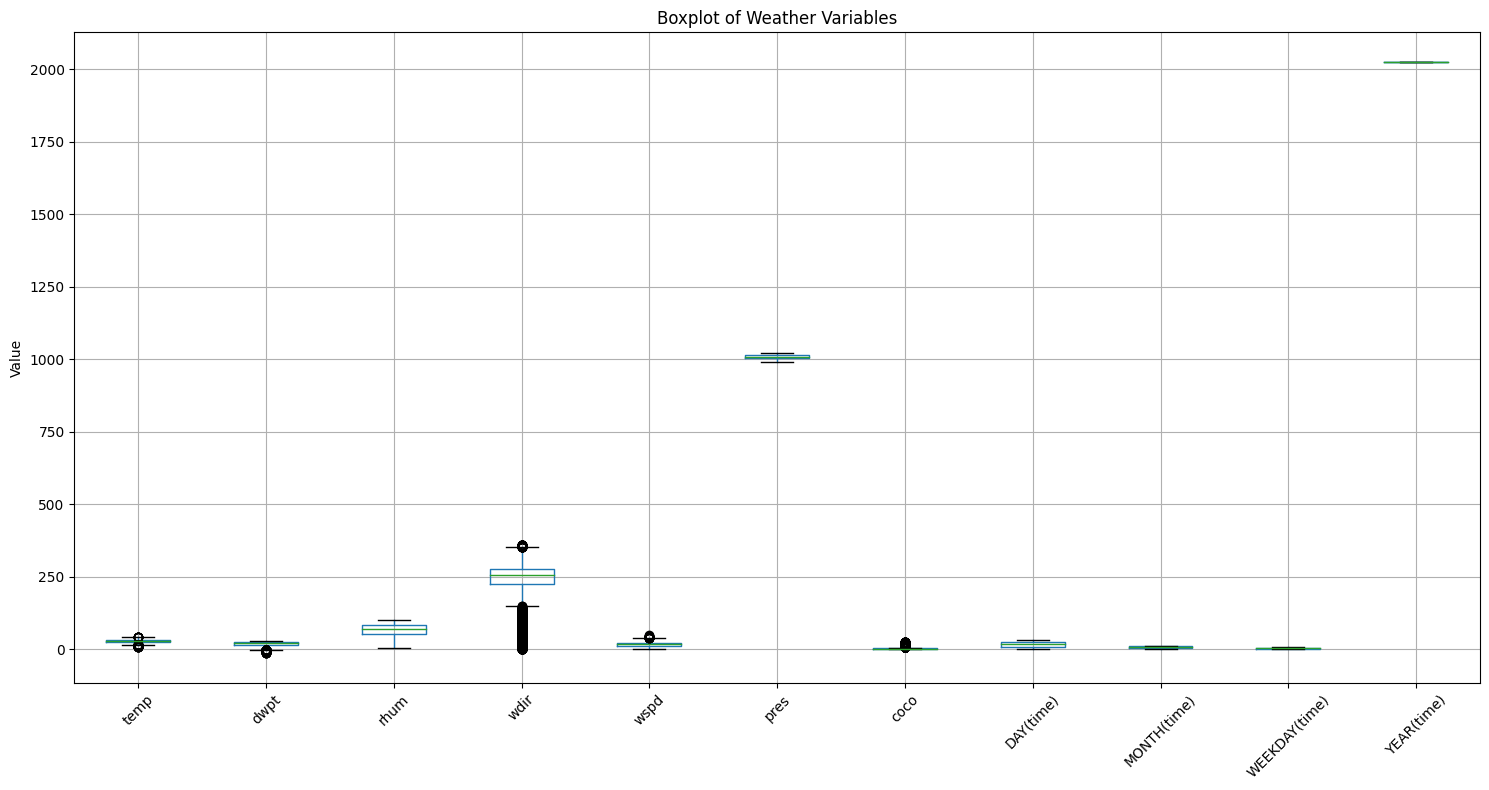

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt


# List of numerical columns 
numeric_cols = ['temp','dwpt','rhum','wdir','wspd','pres','coco','DAY(time)','MONTH(time)','WEEKDAY(time)','YEAR(time)']

# Create boxplot
plt.figure(figsize=(15, 8))
data[numeric_cols].boxplot()
plt.title('Boxplot of Weather Variables')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [91]:
data.describe()

temp         dwpt         rhum         wdir         wspd  \
count  8784.000000  8784.000000  8784.000000  8784.000000  8784.000000   
mean     26.612056    18.367851    65.346653   223.545196    17.725615   
std       5.809553     8.751519    22.406803    92.109801     7.063163   
min       7.700000   -14.100000     5.000000     0.000000     0.000000   
25%      23.500000    13.900000    51.000000   224.000000    12.200000   
50%      27.800000    22.500000    70.000000   254.000000    17.300000   
75%      30.600000    24.800000    84.000000   275.000000    22.700000   
max      42.700000    28.600000   100.000000   360.000000    49.700000   

              pres         coco    DAY(time)  MONTH(time)  WEEKDAY(time)  \
count  8784.000000  8784.000000  8784.000000  8784.000000    8784.000000   
mean   1008.173463     1.996015    15.756831     6.519126       2.986339   
std       6.887072     2.094784     8.812031     3.445858       2.003480   
min     990.800000     1.000000     1.000000     1.000000       0.000000   
25%    1003.100000     1.000000     8.000000     4.000000       1.000000   
50%    1008.700000     1.000000    16.000000     7.000000       3.000000   
75%    1013.800000     3.000000    23.000000    10.000000       5.000000   
max    1022.600000    25.000000    31.000000    12.000000       6.000000   

        YEAR(time)  
count  8784.000000  
mean   2024.325137  
std       0.468453  
min    2024.000000  
25%    2024.000000  
50%    2024.000000  
75%    2025.000000  
max    2025.000000

In [92]:
# Calling AQI data
# Constants
LAT = 24.8607
LON = 67.0011
MAX_DAYS = 92
END_DATE = datetime.today()
START_DATE = END_DATE - timedelta(days=365)  # 1 year of data

all_data = []

# Break into 92-day chunks
current_start = START_DATE
while current_start < END_DATE:
    current_end = min(current_start + timedelta(days=MAX_DAYS), END_DATE)

    params = {
        "latitude": LAT,
        "longitude": LON,
        "start_date": current_start.strftime("%Y-%m-%d"),
        "end_date": current_end.strftime("%Y-%m-%d"),
        "hourly[]": ["pm10", "pm2_5"]
    }

    response = requests.get("https://air-quality-api.open-meteo.com/v1/air-quality", params=params)
    data = response.json()

    if "hourly" in data and all(k in data["hourly"] for k in ["time", "pm10", "pm2_5"]):
        df = pd.DataFrame({
            "Timestamp": data["hourly"]["time"],
            "PM10": data["hourly"]["pm10"],
            "PM2_5": data["hourly"]["pm2_5"]
        })
        all_data.append(df)
        print(f"✅ Retrieved data from {current_start.date()} to {current_end.date()}")
    else:
        print(f"❌ Failed for range {current_start.date()} to {current_end.date()}")
        print(data)

    # Move to next chunk
    current_start = current_end + timedelta(days=1)

# Combine and save
if all_data:
    full_df = pd.concat(all_data, ignore_index=True)
    full_df.to_csv("karachi_aqi_full_year.csv", index=False)
    print(f"📦 Total records: {len(full_df)}")
    print("✅ Saved full dataset to 'karachi_aqi_full_year.csv'")
else:
    print("❌ No data collected.")




✅ Retrieved data from 2024-04-30 to 2024-07-31
✅ Retrieved data from 2024-08-01 to 2024-11-01
✅ Retrieved data from 2024-11-02 to 2025-02-02
✅ Retrieved data from 2025-02-03 to 2025-04-30
📦 Total records: 8784
✅ Saved full dataset to 'karachi_aqi_full_year.csv'


In [93]:
aqi=pd.read_csv("karachi_aqi_full_year.csv")
aqi

Timestamp   PM10  PM2_5
0     2024-04-30T00:00   89.2   30.0
1     2024-04-30T01:00   89.9   29.5
2     2024-04-30T02:00   93.6   30.4
3     2024-04-30T03:00  109.4   32.7
4     2024-04-30T04:00  185.3   35.9
...                ...    ...    ...
8779  2025-04-30T19:00   23.1   16.5
8780  2025-04-30T20:00   23.0   16.2
8781  2025-04-30T21:00   22.8   15.8
8782  2025-04-30T22:00   22.8   15.4
8783  2025-04-30T23:00   22.9   15.1

[8784 rows x 3 columns]

In [94]:
aqi = aqi.drop(aqi.columns[aqi.columns.str.contains('^Unnamed')], axis=1)
aqi.head()

Timestamp   PM10  PM2_5
0  2024-04-30T00:00   89.2   30.0
1  2024-04-30T01:00   89.9   29.5
2  2024-04-30T02:00   93.6   30.4
3  2024-04-30T03:00  109.4   32.7
4  2024-04-30T04:00  185.3   35.9

In [95]:
#Merging both dataset

weather_df = pd.read_csv("Karachi_weather_data.csv")
aqi_df = pd.read_csv("karachi_aqi_full_year.csv")  


weather_df['time'] = pd.to_datetime(weather_df['time'])
aqi_df['Timestamp'] = pd.to_datetime(aqi_df['Timestamp'])

merged_df = pd.merge(weather_df,aqi_df,left_on='time',right_on='Timestamp',how='left')

merged_df = merged_df.drop('Timestamp', axis=1)

merged_df.to_csv('weather_aqi_merged.csv', index=False)
print(merged_df.head(3))

                 time  temp  dwpt  rhum   wdir  wspd    pres  coco  id  \
0 2024-04-29 00:00:00  25.4  16.3  57.0  320.0  21.6  1009.0     1   0   
1 2024-04-29 01:00:00  25.0  16.2  58.0  323.0  18.7  1009.2     1   1   
2 2024-04-29 02:00:00  25.8  15.8  54.0  329.0  18.0  1009.9     1   2   

   DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)  PM10  PM2_5  
0         29            4              0        2024   NaN    NaN  
1         29            4              0        2024   NaN    NaN  
2         29            4              0        2024   NaN    NaN  


In [96]:
data=pd.read_csv('weather_aqi_merged.csv')
data

time  temp  dwpt  rhum   wdir  wspd    pres  coco    id  \
0     2024-04-29 00:00:00  25.4  16.3  57.0  320.0  21.6  1009.0     1     0   
1     2024-04-29 01:00:00  25.0  16.2  58.0  323.0  18.7  1009.2     1     1   
2     2024-04-29 02:00:00  25.8  15.8  54.0  329.0  18.0  1009.9     1     2   
3     2024-04-29 03:00:00  28.7  13.4  39.0  330.0  17.6  1010.6     1     3   
4     2024-04-29 04:00:00  32.3   2.4  15.0  343.0  23.4  1010.8     1     4   
...                   ...   ...   ...   ...    ...   ...     ...   ...   ...   
8779  2025-04-29 19:00:00  27.2  22.6  76.0  289.0  15.1  1004.6     1  8779   
8780  2025-04-29 20:00:00  26.9  22.7  78.0  278.0  15.1  1004.1     1  8780   
8781  2025-04-29 21:00:00  26.8  22.6  78.0  270.0  17.3  1003.6     1  8781   
8782  2025-04-29 22:00:00  26.8  22.4  77.0  269.0  19.4  1003.2     1  8782   
8783  2025-04-29 23:00:00  26.8  22.6  78.0  267.0  19.8  1003.2     1  8783   

      DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)  PM10  PM2_5  
0            29            4              0        2024   NaN    NaN  
1            29            4              0        2024   NaN    NaN  
2            29            4              0        2024   NaN    NaN  
3            29            4              0        2024   NaN    NaN  
4            29            4              0        2024   NaN    NaN  
...         ...          ...            ...         ...   ...    ...  
8779         29            4              1        2025  24.6   16.9  
8780         29            4              1        2025  23.1   15.9  
8781         29            4              1        2025  20.9   14.5  
8782         29            4              1        2025  19.1   13.2  
8783         29            4              1        2025  18.0   12.3  

[8784 rows x 15 columns]

In [97]:
c_data=data.drop('id',axis=1,inplace=True)

In [98]:
data= data.drop(data.columns[data.columns.str.contains('^Unnamed')], axis=1)
data.head()

time  temp  dwpt  rhum   wdir  wspd    pres  coco  \
0  2024-04-29 00:00:00  25.4  16.3  57.0  320.0  21.6  1009.0     1   
1  2024-04-29 01:00:00  25.0  16.2  58.0  323.0  18.7  1009.2     1   
2  2024-04-29 02:00:00  25.8  15.8  54.0  329.0  18.0  1009.9     1   
3  2024-04-29 03:00:00  28.7  13.4  39.0  330.0  17.6  1010.6     1   
4  2024-04-29 04:00:00  32.3   2.4  15.0  343.0  23.4  1010.8     1   

   DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)  PM10  PM2_5  
0         29            4              0        2024   NaN    NaN  
1         29            4              0        2024   NaN    NaN  
2         29            4              0        2024   NaN    NaN  
3         29            4              0        2024   NaN    NaN  
4         29            4              0        2024   NaN    NaN

In [99]:
# Checking and Removing the Outliers

# list of features
weather_features = ['temp', 'dwpt', 'rhum','wdir', 'wspd', 'pres','coco', 'PM10', 'PM2_5','DAY(time)','MONTH(time)','WEEKDAY(time)','YEAR(time)','PM10','PM2_5'] 

# Making a copy
cleaned_data = data.copy()

# Creating a mask to keep original data
mask = np.ones(len(cleaned_data), dtype=bool)

for feature in weather_features:
    Q1 = cleaned_data[feature].quantile(0.25)
    Q3 = cleaned_data[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    feature_mask = (cleaned_data[feature] >= lower_bound) & (cleaned_data[feature] <= upper_bound)
    
    # Combining masks to keep only rows that are NOT outliers
    mask = mask & feature_mask

# Apply mask once at the end
cleaned_data = cleaned_data[mask]

# Final date check
print("Last date after cleaning:", cleaned_data['time'].max())


Last date after cleaning: 2025-04-29 23:00:00


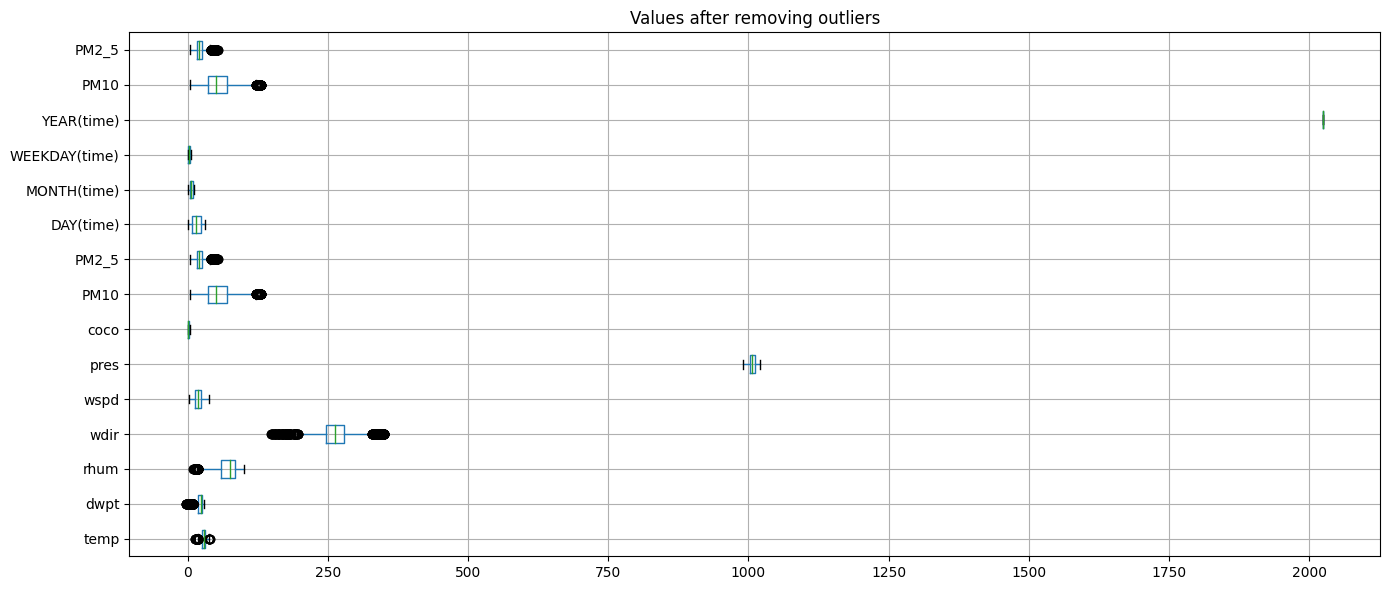

In [100]:
plt.figure(figsize=(14, 6))
cleaned_data.boxplot(column=weather_features, vert=False)
plt.title('Values after removing outliers')
plt.grid(True)
plt.tight_layout()
plt.show()


In [101]:
cleaned_data.tail()

time  temp  dwpt  rhum   wdir  wspd    pres  coco  \
8779  2025-04-29 19:00:00  27.2  22.6  76.0  289.0  15.1  1004.6     1   
8780  2025-04-29 20:00:00  26.9  22.7  78.0  278.0  15.1  1004.1     1   
8781  2025-04-29 21:00:00  26.8  22.6  78.0  270.0  17.3  1003.6     1   
8782  2025-04-29 22:00:00  26.8  22.4  77.0  269.0  19.4  1003.2     1   
8783  2025-04-29 23:00:00  26.8  22.6  78.0  267.0  19.8  1003.2     1   

      DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)  PM10  PM2_5  
8779         29            4              1        2025  24.6   16.9  
8780         29            4              1        2025  23.1   15.9  
8781         29            4              1        2025  20.9   14.5  
8782         29            4              1        2025  19.1   13.2  
8783         29            4              1        2025  18.0   12.3

In [102]:
cleaned_data.count()

time             6059
temp             6059
dwpt             6059
rhum             6059
wdir             6059
wspd             6059
pres             6059
coco             6059
DAY(time)        6059
MONTH(time)      6059
WEEKDAY(time)    6059
YEAR(time)       6059
PM10             6059
PM2_5            6059
dtype: int64

In [103]:
cleaned_data.to_csv('Karachi_Weather_aqi_Dataset.csv',index=False)
data=pd.read_csv('Karachi_Weather_aqi_Dataset.csv')
data

time  temp  dwpt  rhum   wdir  wspd    pres  coco  \
0     2024-04-30 00:00:00  24.4  18.3  69.0  311.0  21.6  1009.4     1   
1     2024-04-30 01:00:00  24.1  13.3  51.0  324.0  19.1  1010.2     1   
2     2024-04-30 02:00:00  25.1  13.6  49.0  328.0  19.4  1010.3     1   
3     2024-04-30 03:00:00  27.9  10.1  33.0  334.0  16.2  1010.6     1   
4     2024-04-30 12:00:00  34.2   6.5  18.0  248.0  26.3  1005.7     1   
...                   ...   ...   ...   ...    ...   ...     ...   ...   
6054  2025-04-29 19:00:00  27.2  22.6  76.0  289.0  15.1  1004.6     1   
6055  2025-04-29 20:00:00  26.9  22.7  78.0  278.0  15.1  1004.1     1   
6056  2025-04-29 21:00:00  26.8  22.6  78.0  270.0  17.3  1003.6     1   
6057  2025-04-29 22:00:00  26.8  22.4  77.0  269.0  19.4  1003.2     1   
6058  2025-04-29 23:00:00  26.8  22.6  78.0  267.0  19.8  1003.2     1   

      DAY(time)  MONTH(time)  WEEKDAY(time)  YEAR(time)   PM10  PM2_5  
0            30            4              1        2024   89.2   30.0  
1            30            4              1        2024   89.9   29.5  
2            30            4              1        2024   93.6   30.4  
3            30            4              1        2024  109.4   32.7  
4            30            4              1        2024  121.5   23.2  
...         ...          ...            ...         ...    ...    ...  
6054         29            4              1        2025   24.6   16.9  
6055         29            4              1        2025   23.1   15.9  
6056         29            4              1        2025   20.9   14.5  
6057         29            4              1        2025   19.1   13.2  
6058         29            4              1        2025   18.0   12.3  

[6059 rows x 14 columns]

In [104]:
# Rename date columns
data = data.rename(columns={
    'DAY(time)': 'Day',
    'MONTH(time)': 'Month',
    'WEEKDAY(time)': 'Weekday',
    'YEAR(time)': 'Year'
})

data = data.drop(columns=[col for col in ['Unnamed: 0'] if col in data.columns])


In [105]:
data['time'] = pd.to_datetime(data['time'])

In [106]:
data.dtypes

time       datetime64[ns]
temp              float64
dwpt              float64
rhum              float64
wdir              float64
wspd              float64
pres              float64
coco                int64
Day                 int64
Month               int64
Weekday             int64
Year                int64
PM10              float64
PM2_5             float64
dtype: object

In [107]:
data.head()

time  temp  dwpt  rhum   wdir  wspd    pres  coco  Day  \
0 2024-04-30 00:00:00  24.4  18.3  69.0  311.0  21.6  1009.4     1   30   
1 2024-04-30 01:00:00  24.1  13.3  51.0  324.0  19.1  1010.2     1   30   
2 2024-04-30 02:00:00  25.1  13.6  49.0  328.0  19.4  1010.3     1   30   
3 2024-04-30 03:00:00  27.9  10.1  33.0  334.0  16.2  1010.6     1   30   
4 2024-04-30 12:00:00  34.2   6.5  18.0  248.0  26.3  1005.7     1   30   

   Month  Weekday  Year   PM10  PM2_5  
0      4        1  2024   89.2   30.0  
1      4        1  2024   89.9   29.5  
2      4        1  2024   93.6   30.4  
3      4        1  2024  109.4   32.7  
4      4        1  2024  121.5   23.2

In [108]:
data.tail()

time  temp  dwpt  rhum   wdir  wspd    pres  coco  Day  \
6054 2025-04-29 19:00:00  27.2  22.6  76.0  289.0  15.1  1004.6     1   29   
6055 2025-04-29 20:00:00  26.9  22.7  78.0  278.0  15.1  1004.1     1   29   
6056 2025-04-29 21:00:00  26.8  22.6  78.0  270.0  17.3  1003.6     1   29   
6057 2025-04-29 22:00:00  26.8  22.4  77.0  269.0  19.4  1003.2     1   29   
6058 2025-04-29 23:00:00  26.8  22.6  78.0  267.0  19.8  1003.2     1   29   

      Month  Weekday  Year  PM10  PM2_5  
6054      4        1  2025  24.6   16.9  
6055      4        1  2025  23.1   15.9  
6056      4        1  2025  20.9   14.5  
6057      4        1  2025  19.1   13.2  
6058      4        1  2025  18.0   12.3

In [109]:
import os

# Skip this part during CI/CD pipeline
if os.environ.get("CI") != "true":
    from google.oauth2 import service_account
    from google.cloud import bigquery
    from pandas_gbq import to_gbq

    credentials = service_account.Credentials.from_service_account_file(
        r"C:\Users\Arbaz Aslam\arbaz-aslam-aqi-prediction-b20d9ef70aaf.json"
    )

    project_id = "arbaz-aslam-aqi-prediction"
    dataset_id = "aqi_feature_store"
    table_id = "weather_aqi_features"

    client = bigquery.Client(credentials=credentials, project=project_id)

    data['time'] = pd.to_datetime(data['time'])
    data = data.sort_values('time')

    to_gbq(
        data,
        destination_table=f"{dataset_id}.{table_id}",
        project_id=project_id,
        if_exists='replace',
        credentials=credentials
    )


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [110]:
import os
import pandas as pd

if os.getenv("CI"):
    # Running in GitHub Actions, use dummy data
    df_features = pd.DataFrame({
        'temperature': [25, 26, 24],
        'humidity': [60, 65, 55],
        'PM10': [80, 85, 90]
    })
    print("Using dummy DataFrame in CI environment")
else:
    # Local run: fetch real data from BigQuery
    from google.oauth2 import service_account
    from pandas_gbq import read_gbq

    credentials = service_account.Credentials.from_service_account_file(r"C:\Users\Arbaz Aslam\arbaz-aslam-aqi-prediction-b20d9ef70aaf.json")

    query = """
    SELECT *
    FROM `arbaz-aslam-aqi-prediction.aqi_feature_store.weather_aqi_features`
    ORDER BY time
    """
    df_features = pd.read_gbq(query, project_id="arbaz-aslam-aqi-prediction", credentials=credentials)


df_features.describe()


time         temp         dwpt         rhum  \
count                        6059  6059.000000  6059.000000  6059.000000   
mean   2024-10-20 16:52:05.862353    28.116554    21.295313    70.060076   
min           2024-04-30 00:00:00    13.800000    -2.400000    10.000000   
25%           2024-07-14 19:30:00    25.900000    18.900000    59.000000   
50%           2024-10-04 22:00:00    28.400000    23.500000    75.000000   
75%           2025-02-14 14:30:00    30.800000    25.000000    85.000000   
max           2025-04-29 23:00:00    40.400000    28.600000   100.000000   
std                           NaN     4.092140     5.667142    19.739380   

              wdir         wspd         pres      coco        Day     Month  \
count  6059.000000  6059.000000  6059.000000    6059.0     6059.0    6059.0   
mean    264.423007    18.997557  1006.897442  1.778016  15.468064  6.441162   
min     148.000000     1.800000   990.800000       1.0        1.0       1.0   
25%     246.000000    13.700000  1002.900000       1.0        8.0       4.0   
50%     262.000000    18.700000  1007.100000       1.0       15.0       6.0   
75%     279.000000    24.100000  1011.800000       3.0       23.0       9.0   
max     351.000000    37.800000  1021.100000       5.0       31.0      12.0   
std      30.878340     6.729988     5.859247  0.926164   8.581774  3.005107   

        Weekday         Year         PM10        PM2_5  
count    6059.0       6059.0  6059.000000  6059.000000  
mean   2.977884  2024.309952    55.845602    22.119442  
min         0.0       2024.0     3.900000     3.800000  
25%         1.0       2024.0    36.800000    16.600000  
50%         3.0       2024.0    49.800000    20.600000  
75%         5.0       2025.0    70.800000    26.300000  
max         6.0       2025.0   130.400000    53.700000  
std    1.986461     0.462512    26.273412     7.989973

In [111]:
df_features.head()

time  temp  dwpt  rhum   wdir  wspd    pres  coco  Day  \
0 2024-04-30 00:00:00  24.4  18.3  69.0  311.0  21.6  1009.4     1   30   
1 2024-04-30 01:00:00  24.1  13.3  51.0  324.0  19.1  1010.2     1   30   
2 2024-04-30 02:00:00  25.1  13.6  49.0  328.0  19.4  1010.3     1   30   
3 2024-04-30 03:00:00  27.9  10.1  33.0  334.0  16.2  1010.6     1   30   
4 2024-04-30 12:00:00  34.2   6.5  18.0  248.0  26.3  1005.7     1   30   

   Month  Weekday  Year   PM10  PM2_5  
0      4        1  2024   89.2   30.0  
1      4        1  2024   89.9   29.5  
2      4        1  2024   93.6   30.4  
3      4        1  2024  109.4   32.7  
4      4        1  2024  121.5   23.2

In [112]:
df_features.tail()

time  temp  dwpt  rhum   wdir  wspd    pres  coco  Day  \
6054 2025-04-29 19:00:00  27.2  22.6  76.0  289.0  15.1  1004.6     1   29   
6055 2025-04-29 20:00:00  26.9  22.7  78.0  278.0  15.1  1004.1     1   29   
6056 2025-04-29 21:00:00  26.8  22.6  78.0  270.0  17.3  1003.6     1   29   
6057 2025-04-29 22:00:00  26.8  22.4  77.0  269.0  19.4  1003.2     1   29   
6058 2025-04-29 23:00:00  26.8  22.6  78.0  267.0  19.8  1003.2     1   29   

      Month  Weekday  Year  PM10  PM2_5  
6054      4        1  2025  24.6   16.9  
6055      4        1  2025  23.1   15.9  
6056      4        1  2025  20.9   14.5  
6057      4        1  2025  19.1   13.2  
6058      4        1  2025  18.0   12.3

In [141]:
# Checking if 'PM2_5' column exists
if 'PM2_5' in df_features.columns:
    # Creating target columns for PM10 and PM2.5 for the next 3 days
    for i in range(1, 4):
        df_features[f'PM10_day{i}'] = df_features['PM10'].shift(-i)
        df_features[f'PM2_5_day{i}'] = df_features['PM2_5'].shift(-i)  # Ensure 'PM2_5' column exists

    # Dropping rows with NaN values
    df_model = df_features.dropna().reset_index(drop=True)

    # Defining feature and target columns
    feature_cols = ['temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres', 'coco', 'Day', 'Month', 'Weekday', 'Year']
    target_cols = [f'PM10_day{i}' for i in range(1, 4)] + [f'PM2_5_day{i}' for i in range(1, 4)]

    X_raw = df_model[feature_cols]
    y_raw = df_model[target_cols]

    # Splitting into training and testing sets
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

    # Scaling features and targets
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X_train = X_scaler.fit_transform(X_train_raw)
    X_test = X_scaler.transform(X_test_raw)

    y_train = y_scaler.fit_transform(y_train_raw)
    y_test = y_scaler.transform(y_test_raw)

    # Saving the scalers
    joblib.dump(X_scaler, "x_scaler.pkl")
    joblib.dump(y_scaler, "y_scaler.pkl")

    # Defining models
    models = {
        'RandomForest': RandomForestRegressor(random_state=42),
        'AdaBoost': AdaBoostRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42, verbosity=0),
        'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
        'CatBoost': CatBoostRegressor(verbose=0, random_state=42)
    }

    # Hyperparameter grids
    param_grids = {
        'RandomForest': {
            'estimator__n_estimators': [100, 200],
            'estimator__max_depth': [5, 10, 15],
            'estimator__min_samples_split': [2, 5]
        },
        'AdaBoost': {
            'estimator__n_estimators': [50, 100],
            'estimator__learning_rate': [0.01, 0.1, 1]
        },
        'XGBoost': {
            'estimator__n_estimators': [100, 200],
            'estimator__learning_rate': [0.01, 0.1, 0.2],
            'estimator__max_depth': [3, 5, 7]
        },
        'LightGBM': {
            'estimator__n_estimators': [100, 200],
            'estimator__learning_rate': [0.01, 0.1],
            'estimator__max_depth': [5, 10],
            'estimator__num_leaves': [31, 50]
        },
        'CatBoost': {
            'estimator__iterations': [100, 200],
            'estimator__learning_rate': [0.01, 0.1],
            'estimator__depth': [5, 10]
        }
    }

    # Wrapping models with MultiOutputRegressor
    wrapped_models = {name: MultiOutputRegressor(model) for name, model in models.items()}

    # Store results
    results = []
    best_estimators = {}

    # Training and tuning
    for name, model in wrapped_models.items():
        print(f"🔍 Tuning {name}...")

        grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_estimators[name] = best_model

        preds_scaled = best_model.predict(X_test)
        preds = y_scaler.inverse_transform(preds_scaled)
        y_test_unscaled = y_scaler.inverse_transform(y_test)

        rmse = np.sqrt(mean_squared_error(y_test_unscaled, preds))
        mae = mean_absolute_error(y_test_unscaled, preds)
        r2 = r2_score(y_test_unscaled, preds)

        results.append((name, grid_search.best_params_, rmse, mae, r2))

    # Define top_3 if results are available
    if results:
        results.sort(key=lambda x: x[2])  # Sort by RMSE
        top_3 = results[:3]
    else:
        top_3 = []

    # Display top 3 models
    if top_3:
        print("\n🏆 Top 3 Models (Lowest RMSE):")
        for i, (name, best_params, rmse, mae, r2) in enumerate(top_3, 1):
            print(f"{i}. {name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.2f}, Best Params={best_params}")
    else:
        print("No valid models found or no results available for logging.")
else:
    print("PM2_5 column is missing from the DataFrame")


🔍 Tuning RandomForest...
🔍 Tuning AdaBoost...
🔍 Tuning XGBoost...
🔍 Tuning LightGBM...
🔍 Tuning CatBoost...

🏆 Top 3 Models (Lowest RMSE):
1. XGBoost: RMSE=8.36, MAE=5.16, R²=0.80, Best Params={'estimator__learning_rate': 0.2, 'estimator__max_depth': 7, 'estimator__n_estimators': 200}
2. CatBoost: RMSE=8.67, MAE=5.52, R²=0.79, Best Params={'estimator__depth': 10, 'estimator__iterations': 200, 'estimator__learning_rate': 0.1}
3. LightGBM: RMSE=8.79, MAE=5.55, R²=0.77, Best Params={'estimator__learning_rate': 0.1, 'estimator__max_depth': 10, 'estimator__n_estimators': 200, 'estimator__num_leaves': 50}


In [143]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Ensure top_3 is defined
if 'top_3' in locals() and top_3:
    mlflow.set_experiment("AQI_Prediction_Experiment")

    with mlflow.start_run(run_name=f"{top_3[0][0]}_Best_Model_Run"):
        # Log hyperparameters
        mlflow.log_params(top_3[0][1])

        # Log evaluation metrics
        mlflow.log_metric("rmse", top_3[0][2])
        mlflow.log_metric("mae", top_3[0][3])
        mlflow.log_metric("r2", top_3[0][4])

        # Create model signature
        signature = infer_signature(X_train_raw, y_scaler.inverse_transform(best_estimators[top_3[0][0]].predict(X_train_raw)))

        # Log and register model
        mlflow.sklearn.log_model(
            sk_model=best_estimators[top_3[0][0]],
            artifact_path="best_model",
            signature=signature,
            registered_model_name="AQI_Best_Model"
        )
else:
    print("No top model available for logging.")


G:\anaconda\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'AQI_Best_Model' already exists. Creating a new version of this model...
Created version '2' of model 'AQI_Best_Model'.


In [144]:
print(type(final_model))


<class 'sklearn.multioutput.MultiOutputRegressor'>


In [145]:
import mlflow
print(mlflow.get_tracking_uri())
#line to loggedin in mlflow ui: 
#mlflow ui --backend-store-uri file:///C:/Users/Arbaz%20Aslam/Python%20work/Arbaz_Aslam_AQI_Project/mlruns

file:///G:/Arbaz_AQI_Project/mlruns
